## 3. Radiative Transfer Models
### By Susan Meerdink<sup>1</sup>

<sup>1</sup>The Machine Learning and Sensing Lab, Electrical and Computer Engineering, University of Florida, Gainesville, FL 32611
<url>https://faculty.eng.ufl.edu/machine-learning/</url>

**Background**  
Around 1987, Alexander F. H. Goetz first identified the need for developing an atmospheric correction technique using radiative transfer modeling (RTM), given the limitations of the empirical approaches for surface reflectance retrievals. RTMs use a theoretical modeling technique built on the physics of energy moving and interacting with the atmosphere and earth’s surface. These models try to account for absorption and scattering effects from atmospheric gases and aerosols. RTMs often produce better results than other methods because they capture the optics/physics of the atmosphere.
<img src="Picture02.png" alt="RS Basics" style="width: 600px;"/>

**Caveats**
* There are many attributes in an RTM that need to be approximated for accurate reflectance retrievals. RTMs require measurements or assumed values of atmospheric variables at the time of data acquisition that may be difficult to obtain, especially when dealing with historical datasets or the inaccessible zones. 
* Performance suffers for high water vapor, extreme viewing angles, surface/atmosphere coupling and heavy aerosol loads. 
* Consistent estimates of surface properties require accurate atmospheric correction across time, variable elevation, and atmospheric attenuation gradients. 
* RTMs are computationally expensive, require domain knowledge, and fine tuning.

**So when is it used?**  
* RTMs are used when there are limited number of targets in the scene to use for calibration using the empirical line method. This also includes collections where it would be infeasible to collect targets such as inhospital terrain, large spatial areas, or repeat collections. These limitations often apply to satellite imagery which is collected at higher temporal scales than drone or airborne and can cover large spatial areas that are not all accessible by humans.
* This method is also used if the data collection occurs near a meterological tower or airport which collects information about the atmosphere.
    * You can also release a radiosonde on a weather balloon during image collection. This data provides a detailed vertical profile of atmospheric gasses and temperature. However, this only provides one vertical profile for your entire image which may not be representative of your entire spatial area.

**Radiative Transfer Model Basics**  
Today there are many RTMs that all have slightly different approaches for retrieving reflectance, but they basically follow the radiative transfer model shown below (Gao and Goetz, 1990):

\begin{equation}
    r_s = \frac{\rho/ T_g - r_a}{T_d T_u + s(\rho/ T_g - r_a)}
\end{equation}

The symbol $\rho$ is the top of atmosphere reflectance, $T_g$ is the gaseous transmittance of the atmosphere, $r_a$ represents the total reflectance of the atmosphere along the optical path, $r_s$ is the surface reflectance, $T_u$ and $T_d$ represent upward and downward transmittances (both direct and diffuse). Here $s$ is the spherical albedo of the atmosphere producing an isotropic irradiance at the surface.

\begin{equation}
 \rho = \frac{\pi L}{F cos(\theta)}    
\end{equation}

where $L$ is the radiance measured by the instrument, $F$ is the solar downward irradiance at the top of the atmosphere, and $\theta$ is the solar zenith angle.The gaseous transmittance can be written as the product of transmittances of all relevant gasses:
 
\begin{equation}
    T_g = T_{H_{2}O} \; T_{O_{2}} \; T_{CO_{2}} \; T_{CH_{4}} \; T_{CO} \; T_{N_{2}O} 
\end{equation}

**Attributes of RTMs**  
There are many attributes in an RTM that need to be approximated for accurate reflectance retrievals. These can be generally grouped into 4 categories:

| Attributes | Constituents |
|---------------------|------|
| Atmospheric Profile | water vapor, oxygen, carbon dioxide, carbon monoxide, methane, nitrous oxide |
| Aerosol Profile | aerosols, dust, pollen, pollutants, smoke, etc. |
| Aerosol Optical Thickness | Atmospheric conditions |
| Geometry | solar angle, viewing angle, sensor altitude, target altitude |

We will go into more detail about each of these attributes below.

_Atmopsheric Profile_
* The atmospheric profile contains atmospheric gasses and water vapor. 
* Abundances of well-mixed gasses are effectively constant, so they are easier to model given a time and location on Earth. 
* However, water vapor concentrations are highly variable spatially, temporally, and vertically in the atmosphere. Often under or over estimation of water vapor concentrations yield the highest errors in retrieving reflectance. 
* Generally, the atmospheric profile attribute is approximated using predefined climates such as Mid-latitude Summer, Sub-Arctic Winter, or Tropical. These have present water vapor and surface air temperature values, which often do not capture specific conditions during an image’s collection. 
* Another way to provide the atmospheric profile is by collecting radiosonde data for that image time and date. This data provides a detailed vertical profile of atmospheric gasses and temperature. However, this is often only for one location and may not be applicable for an entire image scene especially if topography is highly variable.

_Aerosol Profile_
* The aerosol profile attribute is difficult to model and are often the poorest understood component of RTMs. This is mainly due to the highly variable concentrations and limited ability to measure the spatial and vertical distribution of aerosols. 
* Generally, the aerosol profile attribute is approximated using predefined models such as rural, urban, maritime, and tropospheric. These predefined models try to capture general aerosol conditions for an image, but if the image captures any events deviating from the normal (such as fires or dust storms), these models will not return accurate retrievals.

_Aerosol Optical Thickness_
* The aerosol optical thickness attribute is the sum of all absorption and scattering mechanisms as they vary with wavelength for one atmosphere. 
* This value changes depending on the quantity and values for all variables in Table 1. This variable can be complicated to calculate especially if the variables are unknown. 
* Often in RTMs, aerosol optical thickness is approximated using visibility expressed in kilometers.

_Geometry_
* While the other attributes are often approximated, this attribute is always known based on the time of image collection.


In [1]:
# Imports and setup
import numpy as np
import rasterio

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
default_dpi = mpl.rcParamsDefault['figure.dpi']

Ancillary data associated with this file: ['wavelengths', 'rgb_index', 'rgb_image']
There are 273 bands for this 401 by 640 pixel image.


C:\Users\susanmeerdink\AppData\Local\Continuum\anaconda3\lib\site-packages\rasterio\__init__.py:223: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


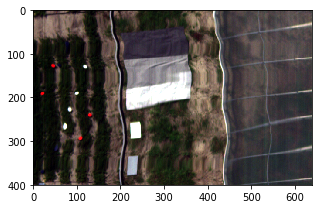

In [2]:
# Load the image
# Note: Image will have georeferencing error because it does gone through georeferencing yet which is normally done after reflectance.
imgFile = rasterio.open('img_radiance', 'r')

# Loading Metadata Data
data_anc = np.load('img_metadata.npz')
print('Ancillary data associated with this file: ' + str(data_anc.files))

# Set some of the variables from the ancillary data
wave = data_anc['wavelengths']
rgb_index = data_anc['rgb_index']
rgb_image = data_anc['rgb_image']

# Grab Some information about this image
pixHeight = rgb_image.shape[0]
pixWidth = rgb_image.shape[1]
numBands = len(wave)
print('There are ' + str(numBands) + ' bands for this ' + str(pixHeight) + ' by ' + str(pixWidth) + ' pixel image.')

# Display Red/Green/Blue or true color image
plt.figure(figsize=(5,5))
plt.imshow(rgb_image)